In [1]:
import torch
from sympy.abc import y
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_DS = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

In [4]:
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(dataset=train_DS, batch_size=BATCH_SIZE, shuffle=True)
Test_DL = torch.utils.data.DataLoader(dataset=train_DS, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
len(train_DL.dataset)

60000

tensor([8, 5, 8, 3, 9, 9, 8, 1, 5, 1, 0, 2, 3, 0, 8, 0, 3, 1, 4, 3, 0, 2, 7, 2,
        5, 2, 0, 5, 7, 4, 9, 3])


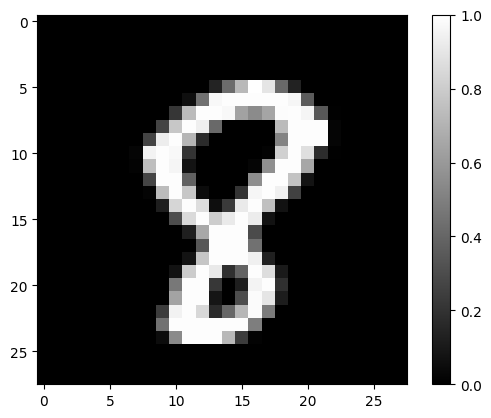

In [6]:
x_batch, y_batch = next(iter(train_DL))
plt.imshow(x_batch[0].squeeze(), cmap="gray")
plt.colorbar()

print(y_batch)
# to_Tensor 에서 normalize 된다.

In [7]:
x_batch.shape

torch.Size([32, 1, 28, 28])

In [8]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Sequential(nn.Linear(28*28, 100), 
                                    nn.ReLU(), 
                                    nn.Linear(100, 10))
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [ ]:
model = MLP().to(DEVICE)
print(model)
train_DL = train_DL
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
# print(x_batch.squeeze())
print(model(torch.flatten(x_batch.to(DEVICE), start_dim=1)).shape)

In [ ]:
LR = 1e-3
EPOCHS = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def Train(model, train_DL, criterion, optimizer, EPOCHS):
    loss_history = []
    NoT = len(train_DL.dataset)
    
    model.train()
    for ep in range(EPOCHS):
        r_loss = 0
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(torch.flatten(x_batch, start_dim=1))
            # y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss accumulatation
            loss_b = loss.item() * x_batch.shape[0]
            r_loss += loss_b
        # print loss
        loss_e = r_loss / NoT
        loss_history.append(loss_e)
        print(f"Epoch {ep+1}/{EPOCHS}, Loss: {round(loss_e,3)}")
        print("-"*20)
        
    return loss_history

### Cross Entropy 확인 (왜 모델에 softmax 를 안 붙였을까?)

In [ ]:
import torch.nn.functional as F

y_hat = torch.randn(3,5)
print(y_hat)
y_batch = torch.randint(5, (3,))
print(y_batch)

In [ ]:
# 방법1
loss = F.cross_entropy(y_hat, y_batch)
print(loss)

# 방법2
criterion = nn.CrossEntropyLoss()
print(criterion(y_hat, y_batch))

# 방법3
y_hat_soft = F.softmax(y_hat, dim=1)
print(y_hat_soft)
loss = 0 
for i, val in enumerate(y_hat_soft):
    print(i, val)
    loss += -torch.log(val[y_batch[i]])
print(loss/3)

In [ ]:
# model = MLP().to(DEVICE)
loss_history = Train(model, train_DL, criterion, optimizer, EPOCHS)

plt.plot(range(1, EPOCHS+1), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Train Loss")
plt.grid()

In [ ]:
save_model_path = "./MNP_MNIST.pth"
torch.save(model.state_dict(), save_model_path)
model.state_dict()

In [ ]:
optimizer

In [10]:
load_model = MLP().to(DEVICE)
save_model_path = "./MNP_MNIST.pth"
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

<All keys matched successfully>

In [11]:
test_batch, _ = next(iter(Test_DL))
print(test_batch.shape)
print(test_batch[0].shape)

torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])


In [12]:
load_model.eval()
with torch.no_grad():
    y = load_model(torch.flatten(test_batch[1].to(DEVICE), start_dim=1))
print(y)

tensor([[-14.8516,  -4.4380,  -4.2844,   6.1833, -10.8188,  -2.5643, -14.3248,
          -5.3916,  -0.9486,  -4.5765]], device='cuda:0')


In [15]:
def Test(model, test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in Test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_hat = model(torch.flatten(x_batch, start_dim=1))
            print(f"y_hat.shape: {y_hat.shape}")
            pred = torch.argmax(y_hat, dim=1)
            print(f"pred: {pred}")
            print(f"y_batch: {y_batch}")
            corrects_b = torch.sum(pred == y_batch).item()
            print(f"corrects_b: {corrects_b}")
            rcorrect += corrects_b
        accuracy_e = rcorrect / len(Test_DL.dataset) * 100
    print(f"Test Accuracy: {rcorrect}/{len(Test_DL.dataset)}   ({round(accuracy_e,1)} %)")

In [16]:
Test(load_model, Test_DL)

y_hat.shape: torch.Size([32, 10])
pred: tensor([7, 5, 0, 3, 4, 8, 2, 1, 8, 5, 1, 0, 5, 9, 7, 0, 7, 4, 9, 4, 3, 5, 2, 8,
        8, 7, 2, 0, 0, 3, 4, 8], device='cuda:0')
y_batch: tensor([7, 5, 0, 3, 4, 8, 2, 1, 8, 5, 1, 0, 5, 9, 7, 0, 7, 4, 9, 4, 3, 5, 2, 8,
        8, 7, 2, 0, 0, 3, 4, 8], device='cuda:0')
corrects_b: 32
y_hat.shape: torch.Size([32, 10])
pred: tensor([3, 5, 6, 9, 2, 0, 5, 2, 2, 6, 2, 8, 6, 5, 0, 8, 8, 4, 8, 3, 6, 0, 2, 6,
        7, 2, 3, 7, 9, 7, 8, 3], device='cuda:0')
y_batch: tensor([3, 5, 6, 9, 2, 0, 5, 2, 2, 6, 2, 8, 6, 5, 0, 8, 8, 4, 8, 3, 6, 0, 2, 6,
        7, 2, 3, 7, 9, 7, 8, 3], device='cuda:0')
corrects_b: 32
y_hat.shape: torch.Size([32, 10])
pred: tensor([9, 4, 1, 6, 2, 3, 2, 0, 1, 9, 2, 3, 9, 0, 2, 6, 4, 0, 0, 9, 2, 1, 8, 2,
        8, 1, 8, 9, 9, 5, 1, 9], device='cuda:0')
y_batch: tensor([9, 4, 1, 6, 2, 3, 2, 0, 1, 9, 2, 3, 9, 0, 2, 6, 4, 0, 0, 9, 2, 1, 8, 2,
        8, 1, 8, 9, 9, 5, 1, 9], device='cuda:0')
corrects_b: 32
y_hat.shape: torch.Size([32,

KeyboardInterrupt: 

In [ ]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r") 

In [ ]:
Test_plot(load_model, Test_DL)